# Model Traning

In [1]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('D:/Users/tonyn/Desktop/da_sci_4th/시계열/fnguide/data/')
from libs.mlutil.pkfold import PKFold # type: ignore

In [2]:
DATA_PATH = 'D:/Users/tonyn/Desktop/da_sci_4th/시계열/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000]
train_y = train_y[:1000]

# Purged K-fold for Cross-Validation 적용

In [3]:
n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold
cv = PKFold(n_cv, t1, 0)

In [4]:
# 최대 20분정도가 소요됩니다. 시간이 부족하다면 파라미터를 조절하여 진행하세요.
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'estimator__max_depth': [3,5,10,20],
             'estimator__max_features': [None, 'sqrt'],
             'estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }



In [5]:
# RandomForest 사용             
rfc = RandomForestClassifier(class_weight='balanced')

In [6]:
# Bagging 적용
bag_rfc = BaggingClassifier(estimator=rfc)

In [7]:
bc_gbm_params = {
    'n_estimators': [5, 10, 20],  # BaggingClassifier의 기본 추정기 개수
    'max_features': [0.5, 0.7],   # BaggingClassifier가 각 추정기를 훈련시킬 때 사용할 특성 비율
    'estimator__n_estimators': [50, 100], 
    'estimator__max_depth': [3, 5, 10, 20], 
    'estimator__learning_rate': [0.01, 0.1], 
    'estimator__subsample': [0.7, 1.0],   
    'estimator__colsample_bytree': [0.7, 1.0], 
    'bootstrap_features': [False, True]    # BaggingClassifier 특성 부트스트랩 여부
}

In [8]:
# XGBoost 사용
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

# Bagging 적용
bag_xgb = BaggingClassifier(estimator=xgb_clf)

In [9]:
# LightGBM 사용
from lightgbm import LGBMClassifier
lgb_clf = LGBMClassifier(objective='binary', class_weight='balanced', random_state=42)

# Bagging 적용
bag_lgb = BaggingClassifier(estimator=lgb_clf)

In [10]:
# GridSearchCV 적용
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)
gs_xgb = GridSearchCV(bag_xgb, bc_gbm_params, cv=cv, n_jobs=-1, verbose=1)
gs_lgb = GridSearchCV(bag_lgb, bc_gbm_params, cv=cv, n_jobs=-1, verbose=1)

In [ ]:
# fit
gs_rfc.fit(train_x, train_y)
print("Random Forest Bagging Best Params:", gs_rfc.best_params_)

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


D:\Users/tonyn/Desktop/da_sci_4th/시계열/fnguide/data\libs\mlutil\pkfold.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_times = pd.Series(index=[self.samples_info_sets.index[start_ix]], data=[self.samples_info_sets[end_ix-1]])


Random Forest Bagging Best Params: {'bootstrap_features': False, 'estimator__max_depth': 10, 'estimator__max_features': None, 'estimator__min_samples_leaf': 10, 'max_features': 0.7, 'n_estimators': 10}


In [12]:
gs_xgb.fit(train_x, train_y)
print("XGBoost Bagging Best Params:", gs_xgb.best_params_)

Fitting 4 folds for each of 768 candidates, totalling 3072 fits


D:\Users/tonyn/Desktop/da_sci_4th/시계열/fnguide/data\libs\mlutil\pkfold.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_times = pd.Series(index=[self.samples_info_sets.index[start_ix]], data=[self.samples_info_sets[end_ix-1]])
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:06:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:06:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\AppData\Roami

XGBoost Bagging Best Params: {'bootstrap_features': False, 'estimator__colsample_bytree': 1.0, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 10, 'estimator__n_estimators': 100, 'estimator__subsample': 1.0, 'max_features': 0.7, 'n_estimators': 20}


In [13]:
gs_lgb.fit(train_x, train_y)
print("LightGBM Bagging Best Parameters:", gs_lgb.best_params_)

Fitting 4 folds for each of 768 candidates, totalling 3072 fits


D:\Users/tonyn/Desktop/da_sci_4th/시계열/fnguide/data\libs\mlutil\pkfold.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_times = pd.Series(index=[self.samples_info_sets.index[start_ix]], data=[self.samples_info_sets[end_ix-1]])


[LightGBM] [Info] Number of positive: 378, number of negative: 292
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2271
[LightGBM] [Info] Number of data points in the train set: 670, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463916 -> initscore=-0.144586
[LightGBM] [Info] Start training from score -0.144586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [15]:
bag_rfc.fit(train_x, train_y)
bag_xgb.fit(train_x, train_y)
bag_lgb.fit(train_x, train_y)

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:36:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:36:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 378, number of negative: 292
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4753
[LightGBM] [Info] Number of data points in the train set: 670, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486390 -> initscore=-0.054454
[LightGBM] [Info] Start training from score -0.054454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

BaggingClassifier(estimator=LGBMClassifier(class_weight='balanced',
                                           objective='binary',
                                           random_state=42))

In [16]:
# best estimator 
gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                   max_depth=10,
                                                   max_features=None,
                                                   min_samples_leaf=10),
                  max_features=0.7)

In [17]:
# best estimator 
gs_xgb_best = gs_xgb.best_estimator_
gs_xgb_best.fit(train_x, train_y)

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:36:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:36:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:36:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


BaggingClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=1.0, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='logloss',
                                          feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=10,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, num_parallel_tree=None, ...),
                  max_features=0.7, n_estimators=20)

In [18]:
# best estimator 
gs_lgb_best = gs_lgb.best_estimator_
gs_lgb_best.fit(train_x, train_y)

[LightGBM] [Info] Number of positive: 378, number of negative: 292
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 670, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516765 -> initscore=0.067084
[LightGBM] [Info] Start training from score 0.067084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

BaggingClassifier(estimator=LGBMClassifier(class_weight='balanced',
                                           learning_rate=0.01, max_depth=5,
                                           n_estimators=50, objective='binary',
                                           random_state=42),
                  max_features=0.5)

In [19]:
# 예측값 확인
pred_y_1 = bag_rfc.predict(test_x)
prob_y_1 = bag_rfc.predict_proba(test_x)

In [20]:
# 예측값 확인
pred_y_2 = gs_rfc_best.predict(test_x)
prob_y_2 = gs_rfc_best.predict_proba(test_x)

In [21]:
# 예측값 확인
pred_y_3 = bag_xgb.predict(test_x)
prob_y_3 = bag_xgb.predict_proba(test_x)

In [22]:
# 예측값 확인
pred_y_4 = gs_xgb_best.predict(test_x)
prob_y_4 = gs_xgb_best.predict_proba(test_x)

In [23]:
# 예측값 확인
pred_y_5 = bag_lgb.predict(test_x)
prob_y_5 = bag_lgb.predict_proba(test_x)

In [24]:
# 예측값 확인
pred_y_6 = gs_lgb_best.predict(test_x)
prob_y_6 = gs_lgb_best.predict_proba(test_x)

In [25]:
# test_y, pred_y를 활용한 지표 적용
pre_y = [pred_y_1, pred_y_2, pred_y_3, pred_y_4, pred_y_5, pred_y_6]
for i in pre_y:
    confusion = confusion_matrix(test_y, i)
    accuracy  = accuracy_score(test_y, i)
    precision = precision_score(test_y, i)
    recall    = recall_score(test_y, i)

    print('================= confusion matrix ====================')
    print(confusion)
    print('=======================================================')
    print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[74 62]
 [10 45]]
정확도:0.6230366492146597, 정밀도:0.4205607476635514, 재현율:0.8181818181818182
================= confusion matrix ====================
[[84 52]
 [12 43]]
정확도:0.6649214659685864, 정밀도:0.45263157894736844, 재현율:0.7818181818181819
================= confusion matrix ====================
[[70 66]
 [11 44]]
정확도:0.5968586387434555, 정밀도:0.4, 재현율:0.8
================= confusion matrix ====================
[[62 74]
 [10 45]]
정확도:0.5602094240837696, 정밀도:0.37815126050420167, 재현율:0.8181818181818182
================= confusion matrix ====================
[[60 76]
 [10 45]]
정확도:0.5497382198952879, 정밀도:0.371900826446281, 재현율:0.8181818181818182
================= confusion matrix ====================
[[77 59]
 [10 45]]
정확도:0.6387434554973822, 정밀도:0.4326923076923077, 재현율:0.8181818181818182


auc:0.7975267379679144
auc:0.7935828877005346
auc:0.7605614973262032
auc:0.7570855614973262
auc:0.7533422459893049
auc:0.7905080213903743


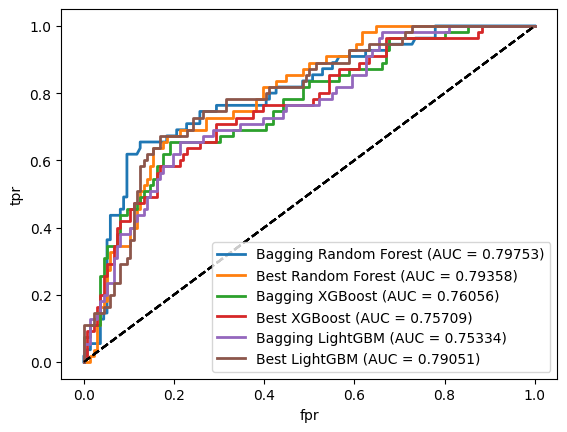

In [38]:
# ROC curve 만들기
prob_y = [prob_y_1, prob_y_2, prob_y_3, prob_y_4, prob_y_5, prob_y_6]
model_names = ['Bagging Random Forest', 'Best Random Forest', 'Bagging XGBoost', 'Best XGBoost', 'Bagging LightGBM', 'Best LightGBM']

for i,a in zip(prob_y,model_names):
    fpr, tpr, thresholds = roc_curve(test_y, i[:, 1])
    auc = roc_auc_score(test_y, i[:, 1])

# ROC curve 시각화
    plt.plot(fpr, tpr, linewidth=2,label=f'{a} (AUC = {auc:.5f})')
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.legend()
    print(f'auc:{auc}')